# Проект прогнозирования ухода кредитных клиентов банков

In [403]:
#Сначала импортируем нужные библиотеки
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

У нас есть датасет с данными о клиентах банка, на основе них нам нужно предсказать какие клиенты банка откажутся от услуг по кредитным картам

In [463]:
data = pd.read_csv("BankChurners.csv")
data = data.iloc[:, :len(data.columns) - 2]
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Можно проверить его на наличие пропусков

In [474]:
np.sum(data.isna())

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Пропусков нет

В стобце Attrition_Flag находится целевая переменная, мы выделили её в y, которая принимает два значения Existing Customer или Attrited Customer. Можно для начала проанализировать её распределение

In [464]:
y = data.iloc[:, 1]

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Count'>

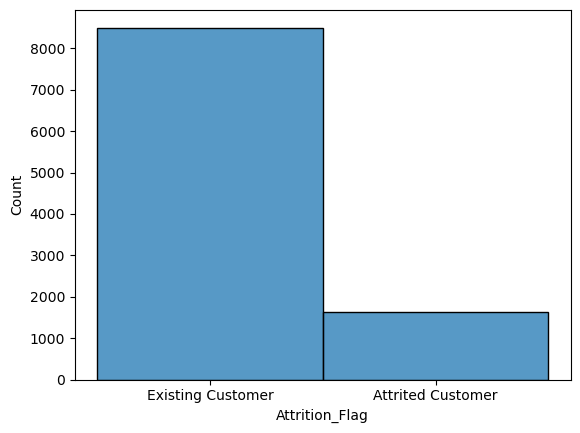

In [465]:
sns.histplot(y)

Можно увидеть, что есть дисбаланс классов. Потенциально это может помешать нормально обучить модель, поэтому попытаемся учесть это в будущем.

Ещё для удобства нужно перекодировать значение целевой переменной в 0 (Existing Customer) и 1 (Attrited Customer)

In [466]:
y = (y == "Attrited Customer").astype(int)

Теперь проанализируем признаки, которые у нас есть, которые мы выделили в X и попробуем сформулировать гипотезы. Мы сразу отбросили столбец CLIENTNUM, потому что это номер каждого клиента, у каждого он уникальный и не влияет на целевую переменную.

In [467]:
X = data.iloc[:, 2:]

Построим heatmap, чтобы посмотреть как признаки кореллируют друг с другом

<AxesSubplot:>

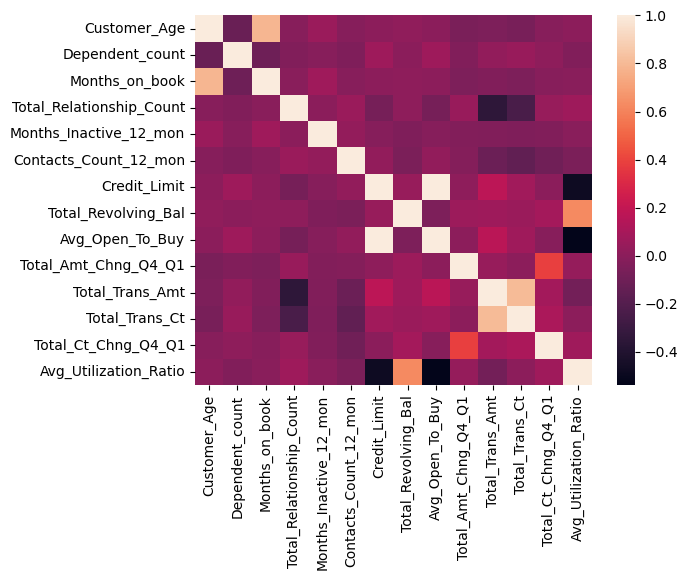

In [468]:
sns.heatmap(X.iloc[:, [0, 2] + list(range(7, 19))].corr())

Можно увидеть, что между Customer_Age и Months_on_book есть корелляция, это логично, чем старше человек, тем дольше у него открыт счёт в банке. Ещё можно увидеть, что есть существенная корелляция между Avg_Open_To_Buy и Credit_Limit, это тоже логично, чем больше лимит по кредитной карте, тем больше человек тратит денег в среднем. Ещё можно увидеть несколько корелляций между похожими переменными, такими как количество и чистая сумма чего-то, они связаны, это тоже логично.

Попробуем нарисовать связь некоторых признаков с целевой переменной

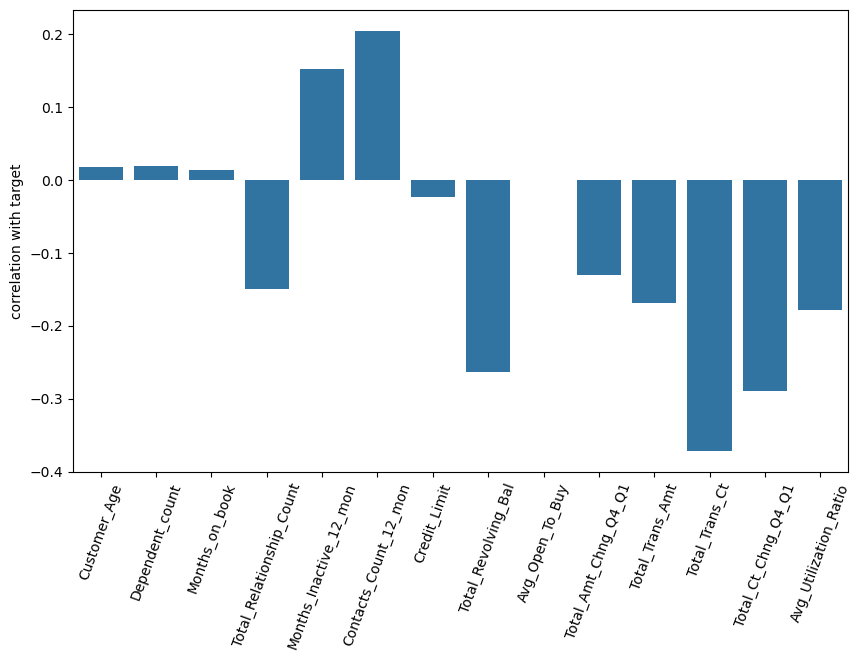

In [470]:
corr_with_y = []
for i in [0, 2] + list(range(7, 19)):
    corr_with_y.append(y.corr(X.iloc[:, i]))
corr_with_y = pd.Series(corr_with_y, index=X.columns[[0, 2] + list(range(7, 19))])
fig, ax = plt.subplots(figsize=(10, 6))
bar = sns.barplot(corr_with_y, ax=ax)
bar.set_xticklabels(labels=X.columns[[0, 2] + list(range(7, 19))], rotation=70)
plt.ylabel("correlation with target")
plt.show()

Можно увидеть, что наибольшую корелляцию с целевой переменной имеют Total_Trans_CT, Total_Revolving_Bal, Total_Ct_CHng_Q4_Q1, все они описывают активность клиента на своём счёте, и логично, что они будут сильно связаны с тем, останется клиент кредитных услуг или нет, так как если он неактивен на своём кредитном счёте, то с большей вероятностью он скоро откажется от этих услуг, если наоборот он активен, то, скорее всего, он не перестанет скоро пользоваться кредитными картами этого банка.

Можно ещё лучше это увидеть, если нарисовать ящики с усами распределения этих признаков у людей, которые перестали пользоваться кредитными картами этого банка и которые не перестали

<AxesSubplot:xlabel='Attrition_Flag', ylabel='Total_Ct_Chng_Q4_Q1'>

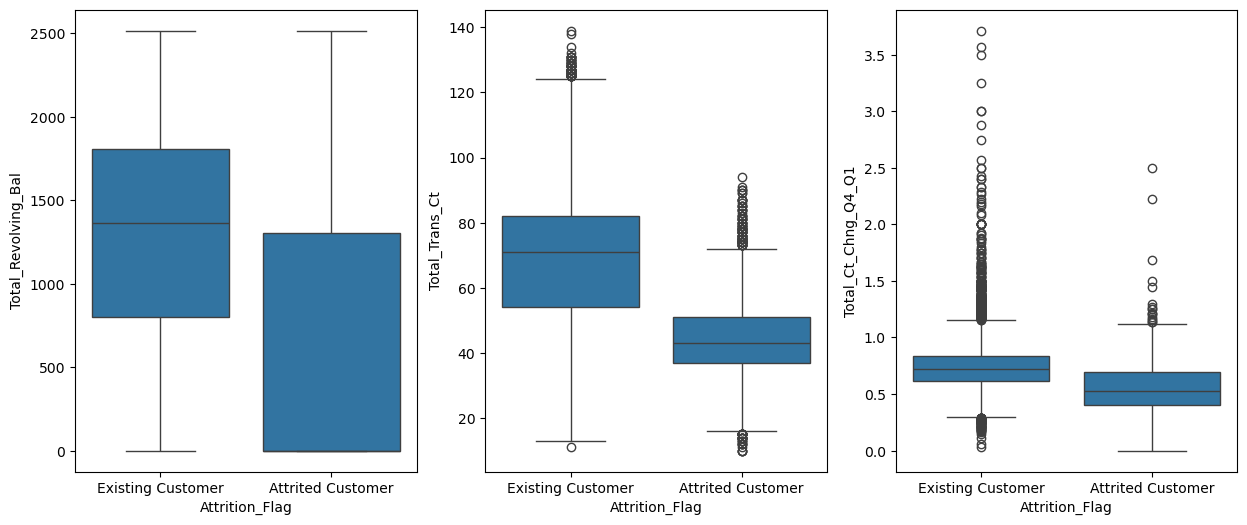

In [412]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(data=data, x="Attrition_Flag", y="Total_Revolving_Bal", ax=ax[0])
sns.boxplot(data=data, x="Attrition_Flag", y="Total_Trans_Ct", ax=ax[1])
sns.boxplot(data=data, x="Attrition_Flag", y="Total_Ct_Chng_Q4_Q1", ax=ax[2])

Теперь перейдём к обработке данных для обучения моделей. Закодируем категориальные признаки, отмасштабируем признаки.

In [413]:
X = pd.get_dummies(X)
scaler = MinMaxScaler()
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X), columns=X.columns)

Разделим выборку на тренировочную и тестовую. На этом этапе нам важно знать про дисбаланс классов и разделять выборку так, чтобы это соотношение не нарушилось в тренировочной и тестовой выборках, мы сделаем это с помощью параметра stratified. 

In [414]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Теперь попробуем обучить несколько моделей и посмотрим на результат

Наша цель найти как можно больше клиентов, которые в будущем откажутся от кредитных услуг банка, чтобы предотвратить это. Но в то же время нам не нужно считать, что все клиенты уйдут. Поэтому будем максимизировать f1-меру.

Сначала обучим модель k ближайших соседей

In [415]:
knn = KNeighborsClassifier(weights="distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f1_score(y_test, y_pred))

0.3392070484581498


In [416]:
scores = pd.DataFrame({})
scores["simple_knn"] = pd.Series(f1_score(y_test, y_pred))

Можно вспомнить, что у нас достаточно много признаков, и многие из них слабо коррелируют с целевой переменной (но между собой коррелируют слабо), поэтому можно оставить только самые важные признаки и обучить модель knn, чтобы улучшить результат.

In [417]:
knn.fit(X_train[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]], y_train)
y_pred = knn.predict(X_test[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]])
print(f1_score(y_test, y_pred))

0.6585365853658537


In [418]:
scores["knn_selected"] = pd.Series(f1_score(y_test, y_pred))

Результат сильно улучшился. Теперь попробуем подобрать параметр k на кросс-валидации для этой модели, чтобы ещё улучшить результат. Для кросс-валидации будем делить выборку так, чтобы сохранять баланс классов.

In [419]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params_knn = {"n_neighbors": [3, 4, 5, 6, 10, 15]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_knn, scoring="f1", cv=stratified_cv)
knn_cv.fit(X_train[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]], y_train)
y_pred = knn_cv.predict(X_test[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]])
print(f1_score(y_test, y_pred))

0.6631578947368421


In [420]:
scores["knn_selected_cv"] = pd.Series(f1_score(y_test, y_pred))

Модель немного улучшилась

Теперь попробуем модель логистической регресии

In [421]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print(f1_score(y_pred, y_test))

0.6136363636363636


In [422]:
scores["simple_log"] = pd.Series(f1_score(y_test, y_pred))

При этом если оставить только важные признаки, то модель ухудшит свой результат

In [423]:
log = LogisticRegression()
log.fit(X_train[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]], y_train)
y_pred = log.predict(X_test[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]])
print(f1_score(y_pred, y_test))

0.56640625


In [424]:
scores["log_selected"] = pd.Series(f1_score(y_test, y_pred))

Теперь попробуем улучшить эту модель с помощью подбора гипермапараметров

In [425]:
params_log = {"C": [0.3, 0.5, 0.7, 1, 1.5, 1.7, 2, 2.3, 2.5, 2.7, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2]}
log_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=params_log, scoring="f1", cv=stratified_cv)
log_cv.fit(X_train, y_train)
y_pred = log_cv.predict(X_test)
print(f1_score(y_test, y_pred))

0.6288848263254113


In [426]:
scores["log_cv"] = pd.Series(f1_score(y_test, y_pred))

Результат немного улучшился, но всё ещё хуже, чем для knn

Теперь попробуем обучить модель svm

In [427]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(f1_score(y_pred, y_test))

0.5714285714285714


In [428]:
scores["simple_svm"] = pd.Series(f1_score(y_test, y_pred))

Теперь попробуем использовать наиболее важные признаки

In [429]:
svm = SVC()
svm.fit(X_train[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]], y_train)
y_pred = svm.predict(X_test[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]])
print(f1_score(y_pred, y_test))

0.6444444444444445


In [430]:
scores["svm_selected"] = pd.Series(f1_score(y_test, y_pred))

Результат улучшился, теперь попробуем подобрать гиперпараметры с помощью кросс-валидации

In [431]:
params_svm = {"C": [0.5, 0.7, 1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]}
svm_cv = GridSearchCV(estimator=SVC(), param_grid=params_svm, scoring="f1", cv=stratified_cv)
svm_cv.fit(X_train[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]], y_train)
y_pred = svm_cv.predict(X_test[["Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]])
print(f1_score(y_test, y_pred))

0.652014652014652


In [432]:
scores["svm_selected_cv"] = pd.Series(f1_score(y_test, y_pred))

Результат немного улучшился

Теперь попробуем обучить модель решающего дерева, можно сразу не пытаться ограничивать признаки, потому что эта модель может сама выбирать важные признаки и использовать их

In [433]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(f1_score(y_pred, y_test))

0.8018575851393189


In [434]:
scores["simple_tree"] = pd.Series(f1_score(y_test, y_pred))

Результат существенно улучшился, попробуем подобрать гиперпараметры с помощью кросс-валидации

In [435]:
params_tree = {"max_depth": [15, 17, 20, 23, 25], "min_samples_leaf": [2, 3, 4, 6]}
tree_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params_tree, scoring="f1", cv=stratified_cv)
tree_cv.fit(X_train, y_train)
y_pred = tree_cv.predict(X_test)
print(f1_score(y_pred, y_test))

0.8


In [436]:
scores["tree_cv"] = pd.Series(f1_score(y_test, y_pred))

Результат немного улучшился

Теперь попробуем обучить модель случайного леса, это композиция нескольких решающих деревьев, она должна ещё сильнее улучшить результат

In [437]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_pred, y_test))

0.8435374149659864


In [438]:
scores["simple_randomforest"] = pd.Series(f1_score(y_test, y_pred))

Результат уже существенно улучшился по сравнению с предыдущими моделями

Тперь попробуем немного улучшить эту модель с помощью кросс-валидации

In [439]:
params_rf = {"n_estimators": [200], "max_depth": [15, 20, 25], "min_samples_leaf": [1, 3, 5]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params_rf, scoring="f1", cv=stratified_cv)
rf_cv.fit(X_train, y_train)
y_pred = rf_cv.predict(X_test)
print(f1_score(y_pred, y_test))

0.8522920203735145


In [440]:
scores["randomforest_cv"] = pd.Series(f1_score(y_test, y_pred))

Результат почти не изменился, но он и так высокий

Теперь попробуем обучить модель градиентного бустинга XGBoost, которая работает на основе решающего дерева, как и случайный лес, но сочетает их по-другому

In [441]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f1_score(y_pred, y_test))

0.9001584786053882


In [442]:
scores["simple_xgb"] = pd.Series(f1_score(y_test, y_pred))

Можно увидеть, что модель ещё сильнее улучшила свой результат

Попробуем улучшить её с помощью кросс-валидации

In [443]:
params_xgb = {"n_estimators": [200], "max_depth": [1, 2, 3, 4, 7], "min_child_weight": [1, 2, 4, 7]}
xgb_cv = GridSearchCV(estimator=XGBClassifier(), param_grid=params_xgb, scoring="f1", cv=stratified_cv)
xgb_cv.fit(X_train, y_train)
y_pred = xgb_cv.predict(X_test)
print(f1_score(y_pred, y_test))

0.9105691056910569


In [444]:
scores["xgb_cv"] = pd.Series(f1_score(y_test, y_pred))

Модель ещё немного улучшилась, это самый лучший результат

In [445]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.97      0.86      0.91       325

    accuracy                           0.97      2026
   macro avg       0.97      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



Мы достигли результата f1-меры в 0.91 и accuracy в 0.97

Можно показать все результаты f1-меры у разных моделей

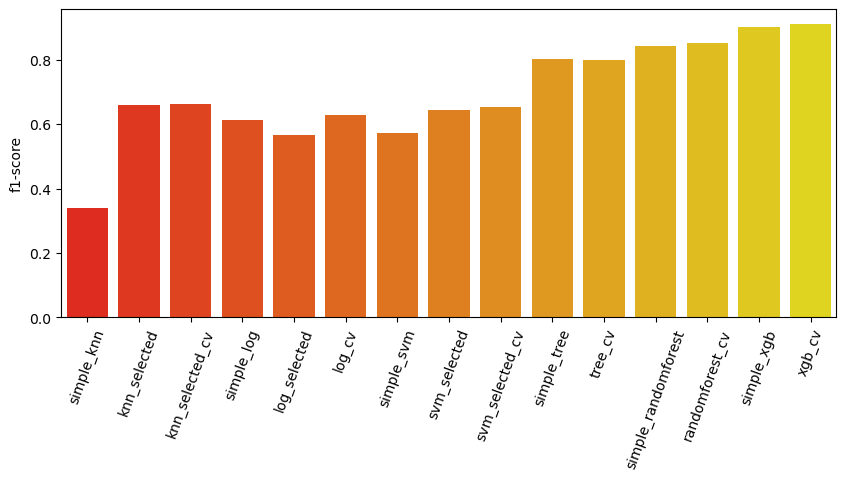

In [461]:
fig, ax = plt.subplots(figsize=(10, 4))
bar1 = sns.barplot(scores, palette="autumn", ax=ax)
bar1.set_xticklabels(labels=scores.columns, rotation=70)
plt.ylabel("f1-score")
plt.show()